
 Solution is correct to tolerance specs.!! 
 



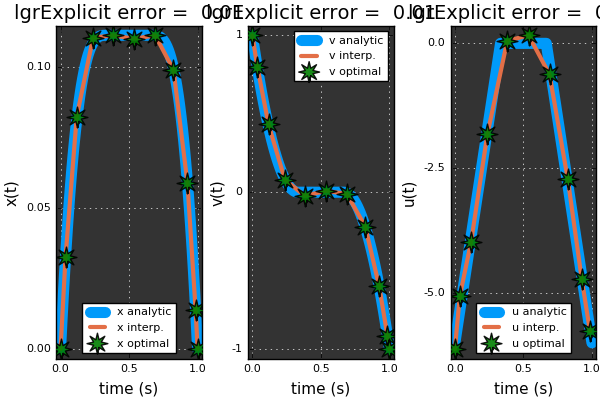

In [13]:
using NLOptControl, JuMP, Ipopt, Parameters, Plots
pyplot()
##################################
# Define NLOptControl problem
##################################
n = NLOpt();
function BrysonDenham{T<:Any}(mdl::JuMP.Model,n::NLOpt,x::Array{T,2},u::Array{T,2}) # dynamic constraint equations
  if n.integrationMethod==:tm
    L = size(x)[1];
  else
    L = size(x)[1]-1;
  end
  dx = Array(Any,L,n.numStates)
  dx[:,1] =  @NLexpression(mdl, [j=1:L], x[j,2] );
  dx[:,2] =  @NLexpression(mdl, [j=1:L], u[j,1] );
  return dx
end
L=1/9;
n = define(n,stateEquations=BrysonDenham,numStates=2,numControls=1,X0=[0.,1],XF=[0.,-1.],XL=[0.,-Inf],XU=[L,Inf],CL=[-Inf],CU=[Inf])
n = configure(n,Ni=1,Nck=[10];(:integrationMethod => :ps),(:integrationScheme => :lgrExplicit),(:finalTimeDV => false),(:tf => 1.0))
#n = configure(n,N=10;(:integrationMethod => :tm),(:integrationScheme => :bkwEuler),(:finalTimeDV => false),(:tf => 1.0))
#n = configure(n,N=10;(:integrationMethod => :tm),(:integrationScheme => :trapezoidal),(:finalTimeDV => false),(:tf => 1.0))

##################################
# Define JuMP problem
##################################
mdl = Model(solver = IpoptSolver(print_level=1));
n,r=OCPdef(mdl,n)
obj = integrate(mdl,n,r.u[:,1];C=0.5,(:variable=>:control),(:integrand=>:squared))
@NLobjective(mdl, Min, obj)
result = solve(mdl)
####################################
## analytic soltion when 0<=L<=1/6
###################################
tol = 10e-3;
if abs(getvalue(obj) - 4/(9*L)) < tol
  print("\n Solution is correct to tolerance specs.!! \n \n")
else
  print(string("\n",
                "-------------------------------------", "\n",
                "The solution is not correct!!", "\n",
                "-------------------------------------", "\n",
                "The following values should be equal:", "\n",
                "4/(9*L)= ",4/(9*L),"\n",
                "getvalue(obj) = ",getvalue(obj),"\n"
                )
        )
end

# analytic soltion for:    0 <= t <= 3L
u1(t) = -2/(3*L)*(1-t/(3*L));
v1(t) = (1 - t/(3*L))^2;
x1(t) = L*(1 - (1 - t/(3*L))^3 );

# analytic soltion for:   3L <= t <= 1-3L
u2(t) = 0;
v2(t) = 0;
x2(t) = L;

# analytic soltion for: 1-3L <= t <= 1
u3(t) = -2/(3*L)*(1 - (1-t)/(3*L) )
v3(t) = -(1 - (1-t)/(3*L) )^2
x3(t) =  L*(1 - (1 - (1-t)/(3*L) )^3 );

pts = 100;
t = linspace(0,n.tf,pts)
x_analytic = zeros(Float64,pts,);
v_analytic = zeros(Float64,pts,);
u_analytic = zeros(Float64,pts,);

for i in 1:pts
if L > 1/6
  warn("\n analytical solution only valid for L < 1/6!! \n")
end
if t[i] < 3*L
  u_analytic[i]=u1(t[i]);
  v_analytic[i]=v1(t[i]);
  x_analytic[i]=x1(t[i]);
elseif ((3*L <= t[i]) && (t[i] <= (1-3*L)))
  u_analytic[i]=u2(t[i]);
  v_analytic[i]=v2(t[i]);
  x_analytic[i]=x2(t[i]);
elseif (((1-3*L) <= t[i]) && (t[i] <= 1))
  u_analytic[i]=u3(t[i]);
  v_analytic[i]=v3(t[i]);
  x_analytic[i]=x3(t[i]);
else
  error(" \n Not setup for outside of this range \n
              TRY: t0 = 0. and tf = 1. \n")
end
end
##################################
# Post Processing
##################################
r=postProcess(n,r); s=Settings();

p1=plot(t,x_analytic, label = "x analytic",w=s.lw1)
plot!(r.t_st,r.X[:,1], label = "x interp.",w=s.lw2)
scatter!(r.t_st,r.X[:,1], label = "x optimal",marker = (:star8, 15, 0.9, :green))
ylabel!("x(t)")
xlabel!("time (s)")

p2=plot(t,v_analytic, label = "v analytic",w=s.lw1)
plot!(r.t_st,r.X[:,2], label = "v interp.",w=s.lw2)
scatter!(r.t_st,r.X[:,2], label = "v optimal",marker = (:star8, 15, 0.9, :green))
ylabel!("v(t)")
xlabel!("time (s)")

p3=plot(t,u_analytic, label = "u analytic",w=s.lw1)
plot!(r.t_ctr,r.U[:,1], label = "u interp.",w=s.lw2)
scatter!(r.t_ctr,r.U[:,1], label = "u optimal",marker = (:star8, 15, 0.9, :green))
ylabel!("u(t)")
xlabel!("time (s)")

plot(p1,p2,p3,layout=(1,3),background_color_subplot=RGB(0.2,0.2,0.2), background_color_legend=RGB(1,1,1))

plot!(foreground_color_grid=RGB(1,1,1))
title!(string(n.integrationScheme, @sprintf(" error =  %0.2f",abs(getvalue(obj) - 4/(9*L)))))

In [14]:
# resize to save
plot!(titlefont=font(10),guidefont=font(14),tickfont=font(12),legendfont=font(12))
plot!(leg=:best)
plot!(size=(700,850))
savefig("ex1_p.png")